# Import and Check OS

In [1]:
import sys


import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import scipy.ndimage as nd

In [2]:
def change_contrast_brightness(image, alpha, beta):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def gamma_adjustment(img_original, gamma):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

In [2]:
if 'win32' in sys.platform:
    ex_filepath = 'F:\Colonies_Data\data\plate 2_24.png'
if 'darwin' in sys.platform:
    ex_filepath = "/Volumes/Samsung_T5/Colonies_Data/data/plate 2_24.png"

# Find the plate

## Find position and radius of the plate

In [3]:
# https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
IMG_SIZE = 1000

image = cv2.imread(ex_filepath)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=int(IMG_SIZE/3), dp=2, minRadius=int(IMG_SIZE/3), maxRadius=int(IMG_SIZE/2))
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    x, y, r = circle_[0]


[[525 461 470]]


## Extract the plate

In [28]:
img = Image.open(ex_filepath).convert("RGB").resize((1000,1000))

npImage=np.array(img)
image = change_contrast_brightness(npImage, .8, 10)

# Create same size alpha layer with circle
alpha = Image.new('L', img.size,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([x-r, y-r, x+r, y+r],0,360,fill=255)

# Convert alpha Image to numpy array
npAlpha=np.array(alpha)

# Add alpha layer to RGB
npImage=np.dstack((image,npAlpha))

# Save with alpha
Image.fromarray(npImage).save('result.png')

# Find Small circles

In [4]:
image = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
image2 = cv2.bitwise_not(image[:,:,:3])
output = image2.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=1, dp=2, minRadius=10, maxRadius=25, param2=37)
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circle_:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
    # show the output image
#     cv2.imshow("output", np.hstack([image2, output]))
#     cv2.waitKey(0)

[[705 933  24]
 [703 935  24]
 [699 937  24]
 ...
 [199 771  11]
 [671 941  11]
 [413 971  11]]


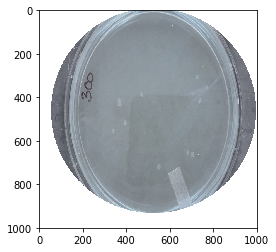

In [9]:
def window_stdev(arr, radius):
    c1 = nd.filters.uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = nd.filters.uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1,:-radius*2+1]

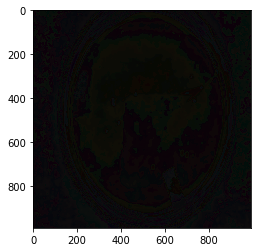

In [17]:
plt.imshow(window_stdev(image[:,:,:3], 5).astype(int))

In [18]:
window_stdev(image[:,:,:3], 5).astype(int)

array([[[14,  6, 11],
        [14,  6, 11],
        [14,  6, 11],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[14,  6, 11],
        [14,  6, 11],
        [14,  6, 11],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[15,  6, 11],
        [14,  6, 11],
        [14,  6, 11],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       ...,

       [[15,  7, 12],
        [15,  7, 12],
        [15,  7, 12],
        ...,
        [12, 11, 12],
        [12, 11, 12],
        [14, 11, 12]],

       [[15,  7, 12],
        [15,  7, 12],
        [15,  7, 12],
        ...,
        [12, 11, 12],
        [14, 11, 12],
        [14, 11, 12]],

       [[15,  7, 12],
        [15,  7, 12],
        [15,  7, 12],
        ...,
        [14, 11, 12],
        [14, 11, 12],
        [14, 11, 12]]])

## Attempting Template Matching

In [30]:
img = cv2.imread(ex_filepath,0)
img2 = img.copy()
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.65
loc = np.where( res >= threshold)
print(loc)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

(array([ 904,  905,  906, ..., 2941, 2941, 2941]), array([2025, 2025, 2025, ..., 1717, 1718, 1719]))


True